# Exploration of Sampling Techniques

This notebook explores sampling techniques for the problem of image captioning. The notebooks tests beam search, argmax, and top-p sampling with the trained VLM models.

Note: the experiments must be run to create saved model weights before running this notebook.

In [1]:
import os
import sys
import torch
import torch.nn as nn
from transformers import AutoTokenizer
import datetime
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

"""
Add support for either running in collab by uploading this notebook and
mounting the directory or locally from the room or experiments folder"
"""
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # NOTE: change the drive path if running with a mounted google drive in collab
    project_root = "/content/drive/Othercomputers/My MacBook Pro/image-captioning"
else:
    cwd = os.getcwd()

    if cwd.endswith("experiments"):
        project_root = os.path.abspath(os.path.join(cwd, '..'))
    else:
        project_root = cwd

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

if IN_COLAB:
    !pip install evaluate > /dev/null 2>&1
    !pip install pycocoevalcap > /dev/null 2>&1


from vision_language_model import VisionLanguageModel
import train as train
import data_processing as dp
import download_data as get_data
import evaluation as eval


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

experiment = "sampling_exploration"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/Othercomputers/My MacBook Pro/image-captioning


In [2]:
# download data, keep it outside of the mounted directory if running in collab to avoid data transfer overhead
if IN_COLAB:
    data_dir = "/content/flickr30k_data"
else:
    data_dir = os.path.join(project_root, "flickr30k_data")

# only download data if it does not already exist
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    get_data.download_and_partition(data_dir)
else:
    print(f"Data already exists in {data_dir}, skipping download.")

# setup saving directories
model_weights_dir = os.path.join(project_root, "model_weights")
evaluations_dir = os.path.join(project_root, "evaluations")
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(evaluations_dir, exist_ok=True)

Data already exists in /content/flickr30k_data, skipping download.


## ViT/GPT2 Sampling Exploration

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="vit",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="gpt2",
    d_model=768,
    tokenizer=tokenizer
    ).to(device)

model_path=os.path.join(model_weights_dir, "experiment_1_finetune_weights_2025-04-13_23-08-39.pt")
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Initializing GPT-2 model...


<All keys matched successfully>

### Beam Search: 2 beams

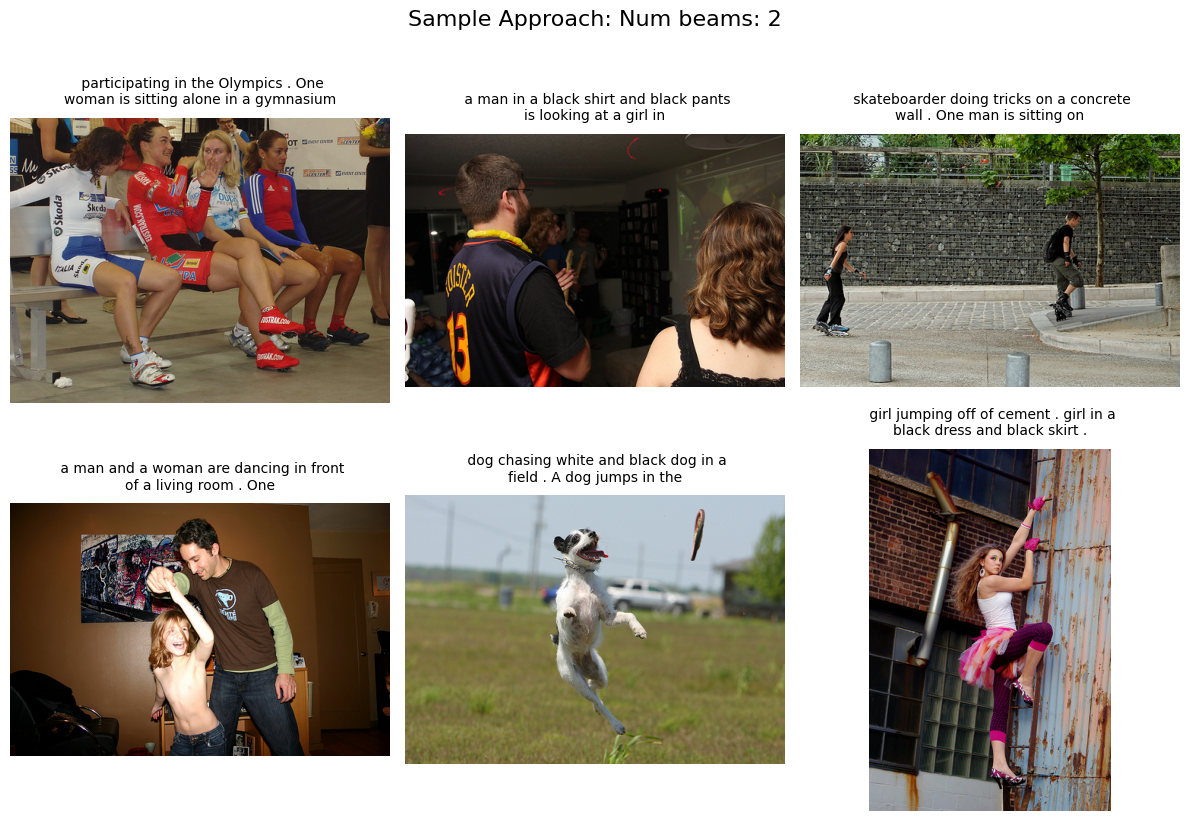

Sample Prediction: [' participating in the Olympics . One woman is sitting alone in a gymnasium'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.1010, CIDEr: 0.2988


In [4]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=250,
    num_beams=2
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

### Top P Sampling: p=0.8, temperature=0.7

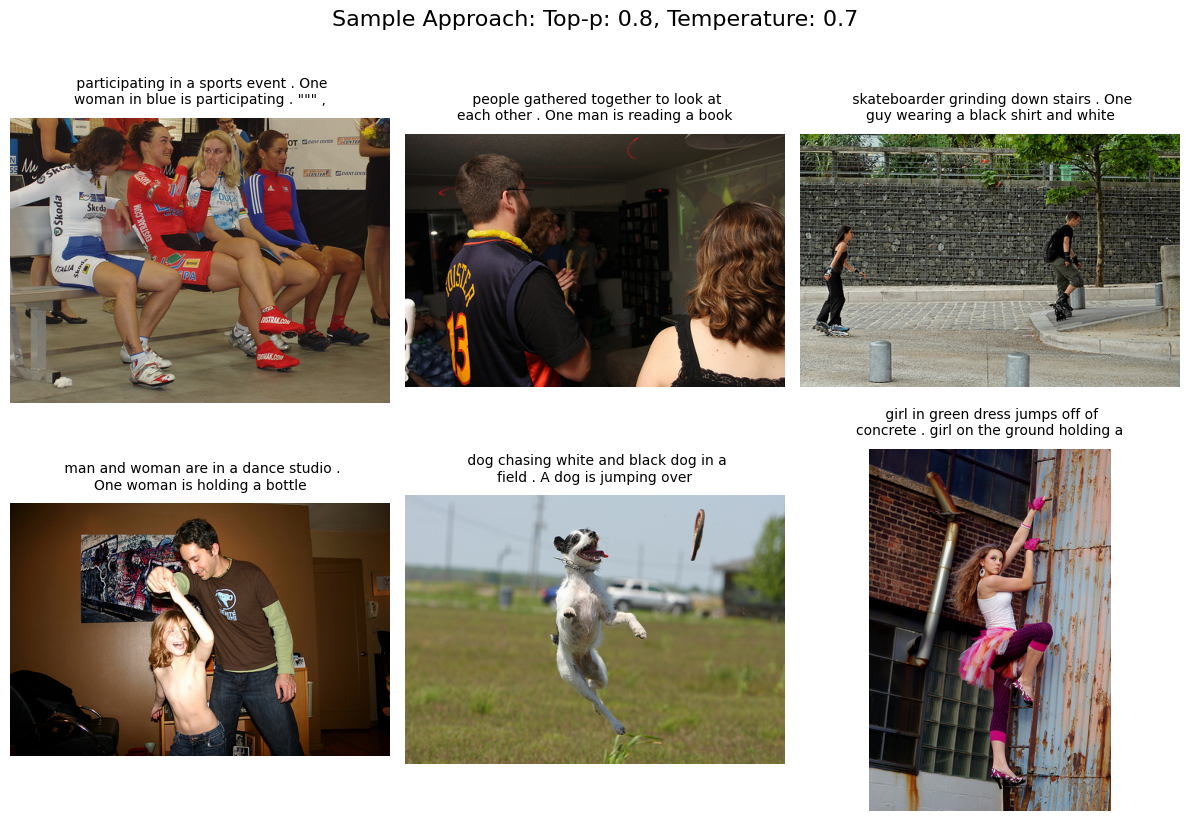

Sample Prediction: [' participating in a sports event . One woman in blue is participating . """ ,'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.0831, CIDEr: 0.2664


In [5]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=250,
    do_sample=True,
    top_p=0.8,
    temperature=0.7
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

### Argmax: 1 beam

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:698: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.6` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


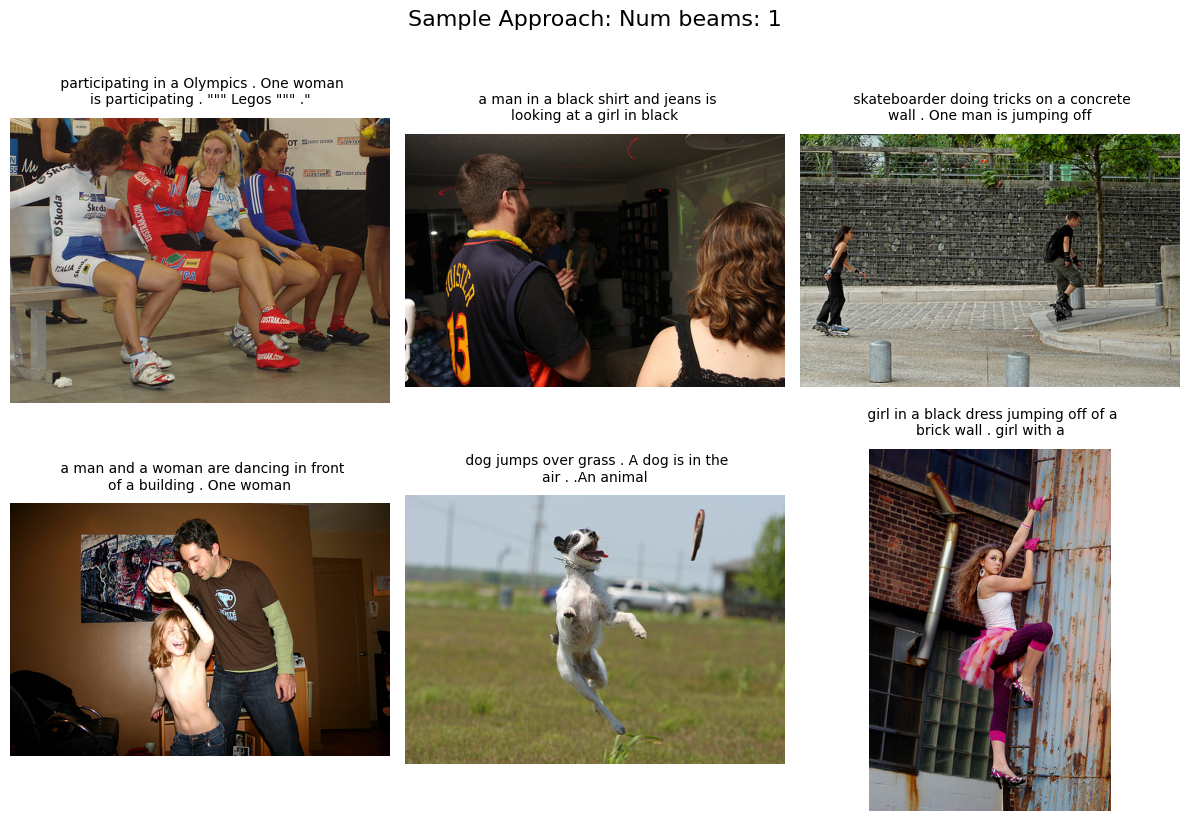

Sample Prediction: [' participating in a Olympics . One woman is participating . """ Legos """ ."'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.0929, CIDEr: 0.2897


In [6]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=250,
    num_beams=1
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

## Clip/Vicuna 7b Sampling Exploration

In [7]:
tokenizer = AutoTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="clip",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="vicuna",
    d_model=4096,
    tokenizer=tokenizer
    ).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
path = os.path.join(model_weights_dir, "experiment_5_pretrain_weights_2025-04-15_09-48-49.pt")
model.image_encoder.projection.load_state_dict(torch.load(path, map_location=device))

Initializing Vicuna model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuratio

<All keys matched successfully>

### Beam Search: 2 beams

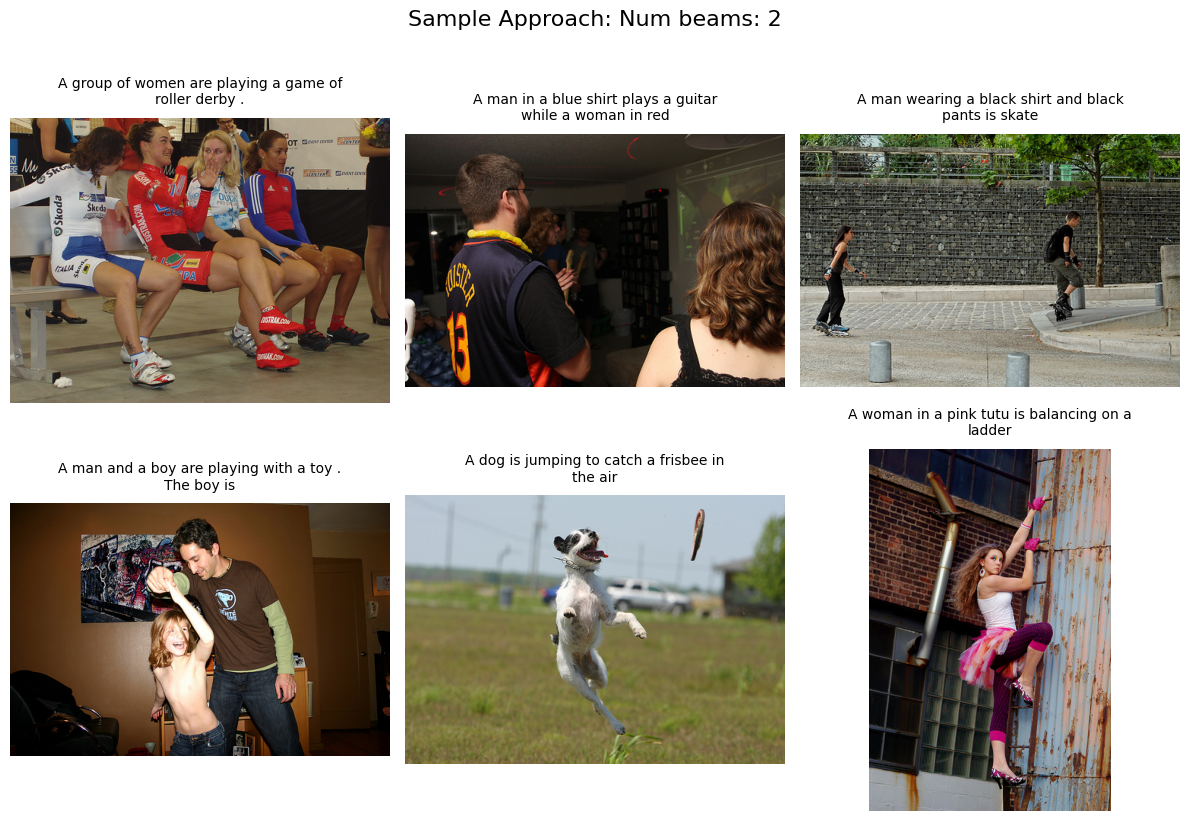

Sample Prediction: ['A group of women are playing a game of roller derby .\n'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.2168, CIDEr: 0.4881


In [8]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=2, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=500,
    num_beams=2
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

### Top P Sampling: p=0.8, temperature=0.7

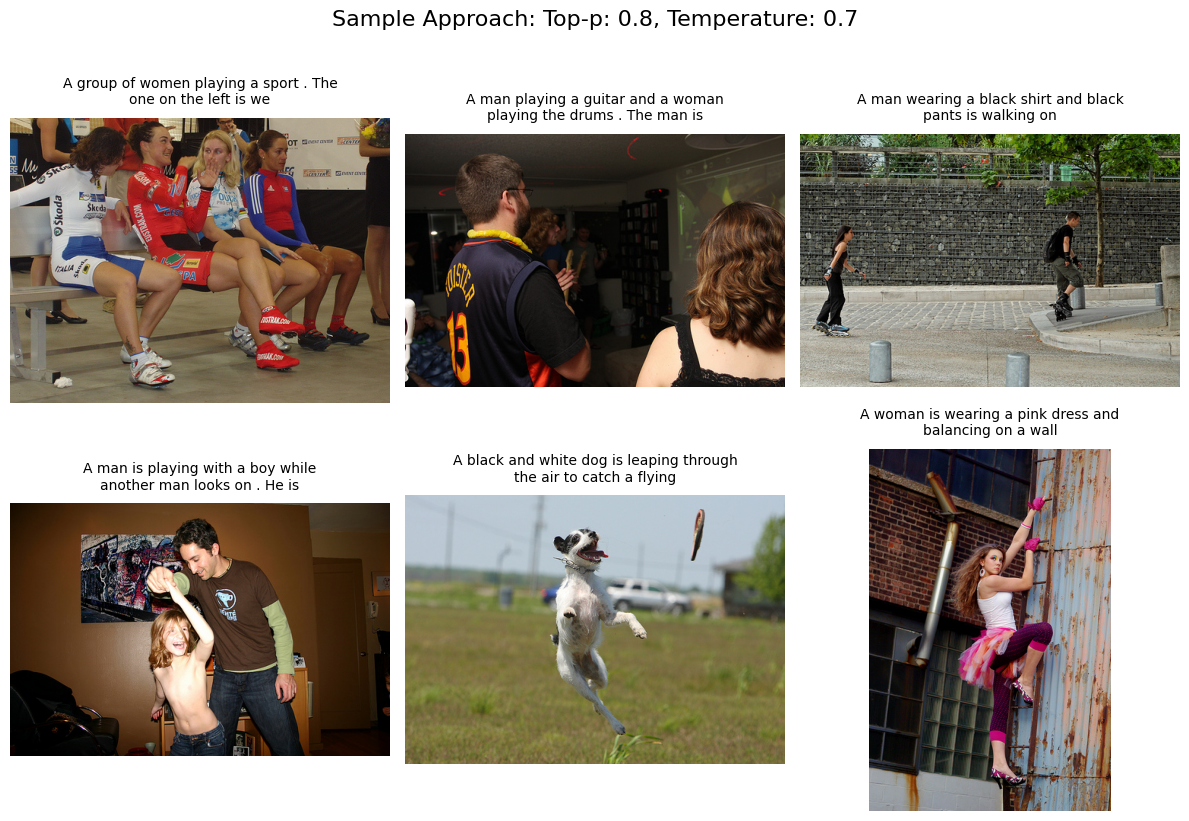

Sample Prediction: ['A group of women playing a sport . The one on the left is we'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.1513, CIDEr: 0.3612


In [9]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=2, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=500,
    do_sample=True,
    top_p=0.8,
    temperature=0.7
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

### Argmax: 1 beam

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:698: 

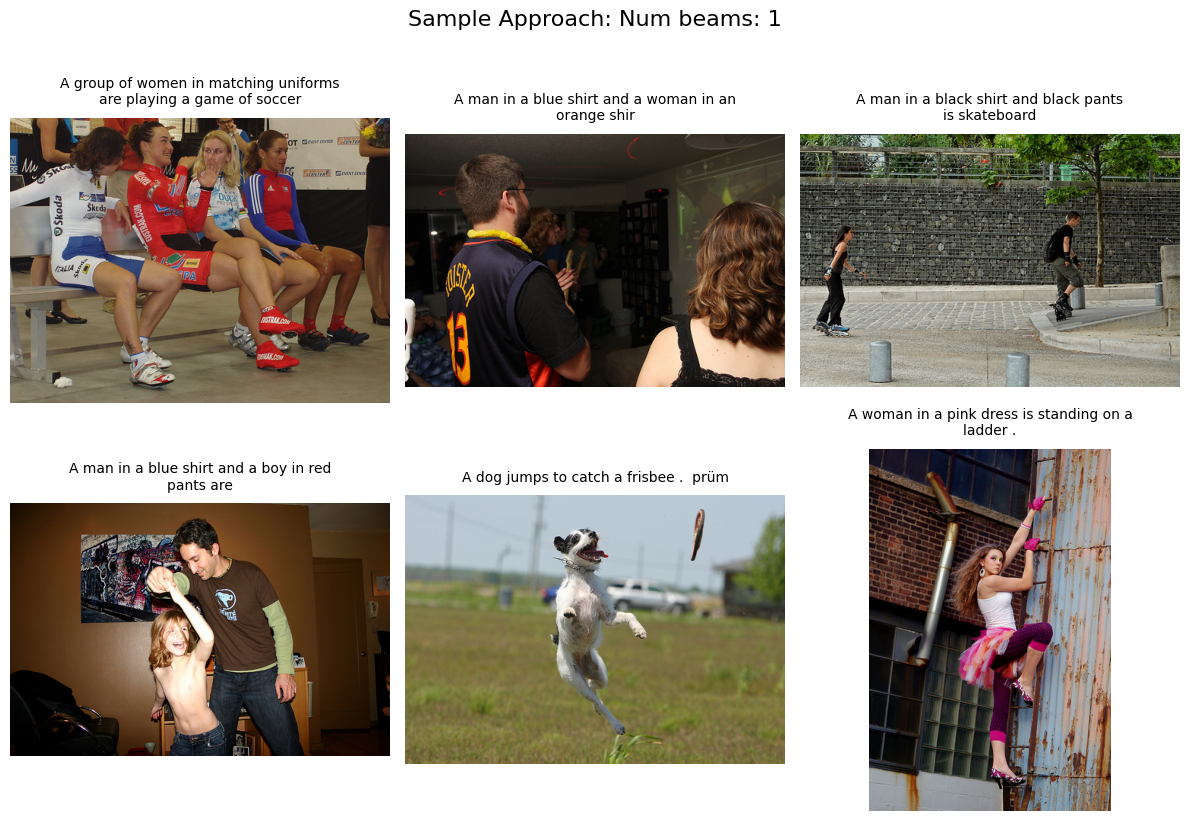

Sample Prediction: ['A group of women in matching uniforms are playing a game of soccer'], Reference: [' Four women wearing bicycle riding clothing sit on a bench .', ' Four women wearing athletic suits are sitting on a bench .', ' A group of female athletes taking a break on the bench .', ' teen athletes are resting on a bench after their run .', ' Girls are talking and explaining about something']
BLEU: 0.2071, CIDEr: 0.4488


In [10]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=2, eval_mode=True, seed=3)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=500,
    num_beams=1
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")